In [39]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

import sys
import numpy as np
from surprise import AlgoBase, Dataset
from surprise.model_selection.validation import cross_validate
import pandas as pd

from scipy.sparse import csr_matrix

import pyspark
from pyspark.sql.types import *
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from sklearn.metrics.pairwise import cosine_similarity


# Build our Spark Session and Context
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext
spark, sc


from pyspark.sql.functions import lit
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.sql.functions import countDistinct, col

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

schema = StructType([
    StructField("user", IntegerType(), True),
    StructField("movie", IntegerType(), True),
    StructField("rating", FloatType(), True),
    StructField("timestamp", IntegerType(), True)])

In [123]:
df_ratings = spark.read.csv('../data/ml-latest-small/ratings.csv', sep =',', header=True, schema=schema)
df_ratings.drop('timestamp')

DataFrame[user: int, movie: int, rating: float]

In [52]:
# df = pd.read_csv('../data/ml-latest-small/ratings.csv')
# df = df.drop('timestamp', axis = 1)
# df = df.pivot_table(values='rating', index='userId', columns='movieId')
# df = spark.createDataFrame(df)
df_ratings.show()

+----+-----+------+
|user|movie|rating|
+----+-----+------+
|   1|    1|   4.0|
|   1|    3|   4.0|
|   1|    6|   4.0|
|   1|   47|   5.0|
|   1|   50|   5.0|
|   1|   70|   3.0|
|   1|  101|   5.0|
|   1|  110|   4.0|
|   1|  151|   5.0|
|   1|  157|   5.0|
|   1|  163|   5.0|
|   1|  216|   5.0|
|   1|  223|   3.0|
|   1|  231|   5.0|
|   1|  235|   4.0|
|   1|  260|   5.0|
|   1|  296|   3.0|
|   1|  316|   3.0|
|   1|  333|   5.0|
|   1|  349|   4.0|
+----+-----+------+
only showing top 20 rows



In [62]:
df = df_ratings.toPandas()
df['rating'].unique()

array([4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5], dtype=float32)

In [30]:
print('Number of unique users: {}'.format(df_ratings.select('user').distinct().count()))
print('Number of unique movies: {}'.format(df_ratings.select('movie').distinct().count()))
print('Number of rating: {}'.format(df_ratings.count()))

Number of unique users: 610
Number of unique movies: 9724
Number of rating: 100836


In [31]:
train, test = df_ratings.randomSplit([0.8, 0.2], seed=100)

Max Ratings: 2201
Min Ratings: 14


<AxesSubplot:>

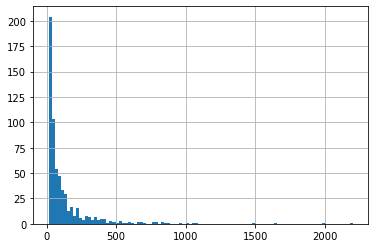

In [49]:
user_count = train.groupBy('user').count().toPandas()

print('Max Ratings: {}'.format(user_count['count'].max()))
print('Min Ratings: {}'.format(user_count['count'].min()))
user_count['count'].hist(bins = 100)

Max Ratings: 264
Min Ratings: 1


<AxesSubplot:>

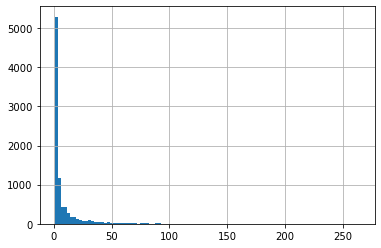

In [50]:
movie_count = train.groupBy('movie').count().toPandas()

print('Max Ratings: {}'.format(movie_count['count'].max()))
print('Min Ratings: {}'.format(movie_count['count'].min()))
movie_count['count'].hist(bins = 100)

Max Ratings: 65
Min Ratings: 1


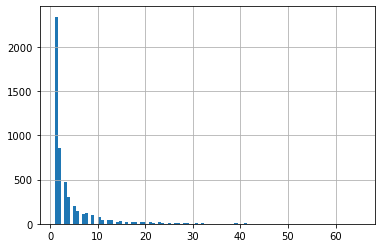

In [86]:
movie_count = test.groupBy('movie').count().toPandas()

print('Max Ratings: {}'.format(movie_count['count'].max()))
print('Min Ratings: {}'.format(movie_count['count'].min()))
movie_count['count'].hist(bins = 100)
train = train.withColumn("imp_rating", lit(1))

In [127]:
test_df = test.toPandas()
train_df = test.toPandas()

len( np.setdiff1d(test_df.user.unique(), train_df.user.unique()))

0

In [129]:
len( np.setdiff1d(test_df.movie.unique(), train_df.movie.unique()))

0

In [298]:
als_model = ALS(userCol='user',
                itemCol='movie',
                ratingCol='rating',
                nonnegative=True,
                regParam=0.1,
                rank=10,
                coldStartStrategy='drop'
               )

als = als_model.fit(train)

NameError: name 'one_row_spark_df' is not defined

In [307]:
train_df = train.toPandas()
predictions = als.transform(test)
predictions_df = predictions.toPandas().fillna(train_df['rating'].mean())
predictions_df

,user,movie,rating,prediction
0,91,471,1.0,2.866915
1,603,471,4.0,3.002979
2,474,471,3.0,3.484408
3,500,471,1.0,3.184305
4,387,471,3.0,3.208374
...,...,...,...,...
19324,564,84374,3.0,3.163281
19325,562,84374,3.5,3.297566
19326,47,145839,3.5,1.539149
19327,210,147378,4.5,3.305344


In [308]:
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['prediction'])**2

In [309]:
np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

0.8764738614204013

In [310]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
predictions_df.head()

,user,movie,rating,prediction,squared_error
0,91,471,1.0,2.866915,3.485371
1,603,471,4.0,3.002979,0.994052
2,474,471,3.0,3.484408,0.234651
3,500,471,1.0,3.184305,4.771188
4,387,471,3.0,3.208374,0.043420


In [311]:
evaluator.evaluate(predictions_df)

AttributeError: 'DataFrame' object has no attribute '_jdf'

In [315]:
userRecs = als.recommendForAllUsers(5)

In [316]:
userRecs = userRecs.toPandas()
userRecs.head()

,user,recommendations
0,471,"[(89904, 4.746745586395264), (26171, 4.6714754..."
1,463,"[(84847, 5.245168685913086), (68945, 5.0938134..."
2,496,"[(8477, 5.2293806076049805), (26810, 5.0849933..."
3,148,"[(932, 4.569633960723877), (183897, 4.42667388..."
4,540,"[(84847, 5.273715972900391), (68945, 5.2368845..."


In [317]:
user = userRecs.set_index('user')

In [318]:
user['recommendations']

user
471    [(89904, 4.746745586395264), (26171, 4.6714754...
463    [(84847, 5.245168685913086), (68945, 5.0938134...
496    [(8477, 5.2293806076049805), (26810, 5.0849933...
148    [(932, 4.569633960723877), (183897, 4.42667388...
540    [(84847, 5.273715972900391), (68945, 5.2368845...
                             ...                        
208    [(68945, 4.630026340484619), (3379, 4.63002634...
401    [(183897, 4.685441493988037), (33649, 4.668534...
422    [(8477, 4.745815277099609), (68945, 4.64094924...
517    [(86320, 5.07235050201416), (40697, 4.58608913...
89     [(139640, 4.924813270568848), (131610, 4.92481...
Name: recommendations, Length: 610, dtype: object

In [319]:
lst = []
for item in user['recommendations'][472]:
    lst.append(item[0])
print(lst)

[932, 1939, 3022, 319, 5490]


In [320]:
df_movies = pd.read_csv('../data/ml-latest-small/movies.csv')
df_movies = df_movies.set_index('movieId')
df_movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [321]:
for movie in lst:
    print(df_movies.loc[movie, 'title'])

Affair to Remember, An (1957)
Best Years of Our Lives, The (1946)
General, The (1926)
Shallow Grave (1994)
The Big Bus (1976)
